# Doppler Shift

This recreates this example:

![example](../../paper/figures/rotation_doppler_outflow.png)

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import os

% matplotlib inline

In [82]:
plt.rc('text', usetex=True)
plt.rc('font', size=30)

In [3]:
def read_data(vrot=0, vout=5, logtau=5, input_dir="../../data/"):
    tau_name = 'tau10E' + str(logtau)
    vrot_name = 'vrot' + str(vrot)
    vout_name = 'vout' + str(vout)
    filename = tau_name + '_' + vrot_name + '_' + vout_name + '_out.ascii'
    fname =  os.path.join(input_dir, tau_name, vrot_name, vout_name, filename)

    dtype=[('x', 'f8'),('y', 'f8'), ('z', 'f8'),
           ('k_x', 'f8'),('k_y', 'f8'),('k_z', 'f8'),
           ('x_frec', 'f8'), ('escaped', 'i8'), ('n_scattering', 'i8')]

    df = np.loadtxt(fname, skiprows=1, dtype=dtype)
    df = df[df['escaped']==0]
    return df

In [68]:
def get_angles(num_thetas, num_phis):
    '''Get the angles'''
    cos_thetas = np.linspace(0,1,num_thetas+1) 
    cos_thetas_plus = np.linspace(-1,0,num_thetas+1)
    thetas = np.sort(np.arccos(cos_thetas))
    thetas_plus = np.arccos(cos_thetas_plus)
    phis = np.linspace(0,2*np.pi,num_phis+1) 
    return thetas, thetas_plus, phis

def get_unit_r_sphere(data):
    '''Re-scale positions on the sphere at which the photons escaped'''
    r_norm = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
    x_sphere = data['x'] / r_norm
    y_sphere = data['y'] / r_norm
    z_sphere = data['z'] / r_norm
    return x_sphere, y_sphere, z_sphere

# Auxiliar functions

def filter_by_theta(data, theta_min, theta_max):
    '''Return only the x_frec_escaped between those upper and lower angles'''
    
    cos_theta_k_out = np.abs(data['k_z'])
    ii = (cos_theta_k_out<np.abs(np.cos(theta_min))) 
    ii = ii & (cos_theta_k_out>np.abs(np.cos(theta_max)))
    return data[ii]

def filter_by_direction(data):
    '''Return only the x_frec_escaped between those upper and lower angles'''
    
    r_mag = (data['x']**2 + data['y']**2)**0.5
    r_x = data['x']/r_mag
    r_y = data['y']/r_mag
    
    dot = r_x*data['k_x'] + r_y*data['k_y']
    proj_x = data['k_x'] - r_x*dot
    proj_y = data['k_y'] - r_y*dot
    
    perp_x = -r_y
    perp_y = r_x
    
    para = proj_x*perp_x + proj_y*perp_y
    
    inds = np.where(para >= 0) #parallel (red)
    inds_c = np.where(para < 0) #antiparallel (blue)
    
    return data[inds], data[inds_c]

def get_atom_velocities(x_unitary, y_unitary, z_unitary, vrot):
    '''Defines new atom velocities based on vrot (vr) '''
    v_x = - y_unitary * vrot
    v_y = x_unitary * vrot
    v_z = np.zeros(len(z_unitary))
    return {'x':v_x, 'y':v_y, 'z':v_z}

def doppler_shift(data, vrot=0.0, v_th=12.86):
    '''updates old_data adding doppler shifts. the result is stored in new_data'''
    
    new_data = data.copy()
    
    new_data['x'], new_data['y'], new_data['z'] = get_unit_r_sphere(data)
    
    atom_velocities = get_atom_velocities(
                        new_data['x'], new_data['y'], new_data['z'], vrot=vrot)
    
    new_data['x_frec'] = data['x_frec'] 
    new_data['x_frec'] += atom_velocities['x']*data['k_x']/v_th
    new_data['x_frec'] += atom_velocities['y']*data['k_y']/v_th
    new_data['x_frec'] += atom_velocities['z']*data['k_z']/v_th
    
    return new_data

In [69]:
def plot_spectra(data, min_theta, max_theta, alpha=1.0, v_th=12.86, lw=2, label='label', color='black'):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    a = plt.hist(-data_theta['x_frec']*v_th, histtype='step', 
                 fill=False, stacked=False, normed=True, color=color,
                 linewidth=lw, bins=50, alpha=alpha, label=label)

In [24]:
def plot_spectra_sides(data, min_theta, max_theta, alpha=1.0, v_th=12.86, lw=2, color='black'):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    data_red, data_blue = filter_by_direction(data_theta)
    r = plt.hist(-data_red['x_frec']*v_th, histtype='step', 
                 fill=False, stacked=False, normed=True, color='red',
                 linewidth=lw, bins=50, alpha=alpha, label='Red')
    b = plt.hist(-data_blue['x_frec']*v_th, histtype='step', 
                 fill=False, stacked=False, normed=True, color='blue',
                 linewidth=lw, bins=50, alpha=alpha, label='Blue')

In [90]:
def plot_redshift(vout, vrot, logtau):
    mint= 0
    maxt = 0.5
    data = read_data(vout=vout, vrot=vrot, logtau=logtau)
    
    fig = plt.figure(1, (14., 9.))
    plot_spectra(data, min_theta=mint, max_theta=maxt, lw=3, label='Full Spectra')
    plot_spectra_sides(data, min_theta=mint, max_theta=maxt, lw=1)
    plt.legend(loc=2)
    plt.xlabel('$\mathrm{V}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)')
    plt.ylabel('$\mathrm{Intensity}$ ($\mathrm{Arbitrary}$ $\mathrm{Units}$)')

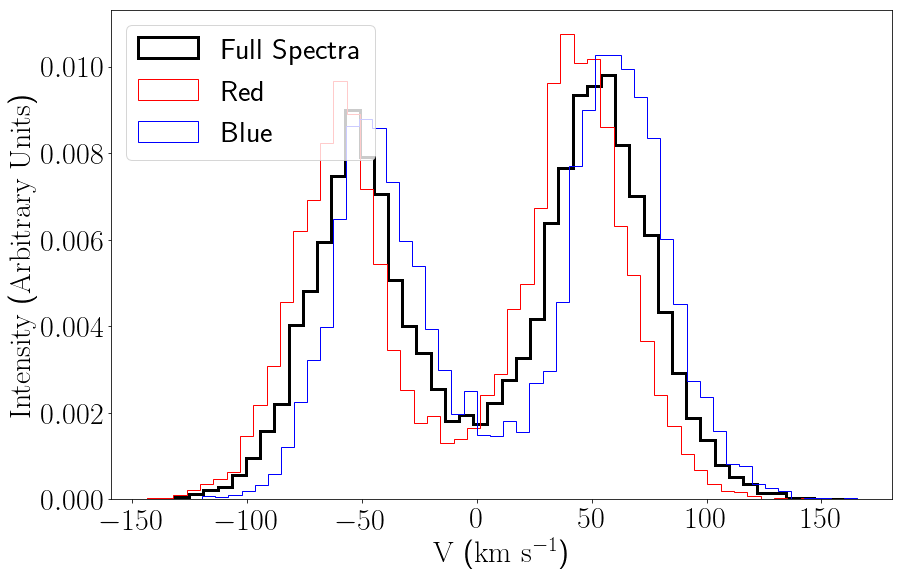

In [91]:
plot_redshift(vout=5, vrot=100, logtau=5)

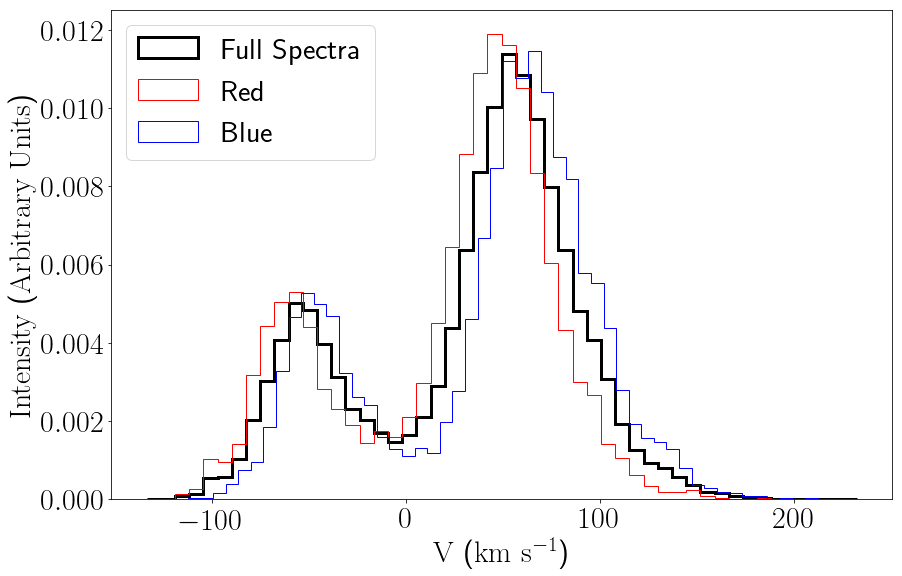

In [92]:
plot_redshift(vout=25, vrot=100, logtau=5)

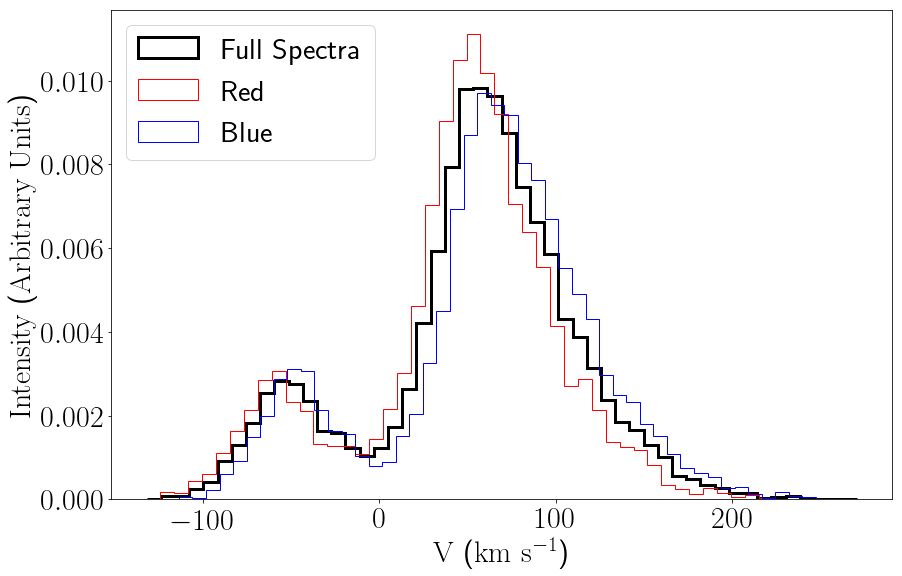

In [93]:
plot_redshift(vout=50, vrot=100, logtau=5)

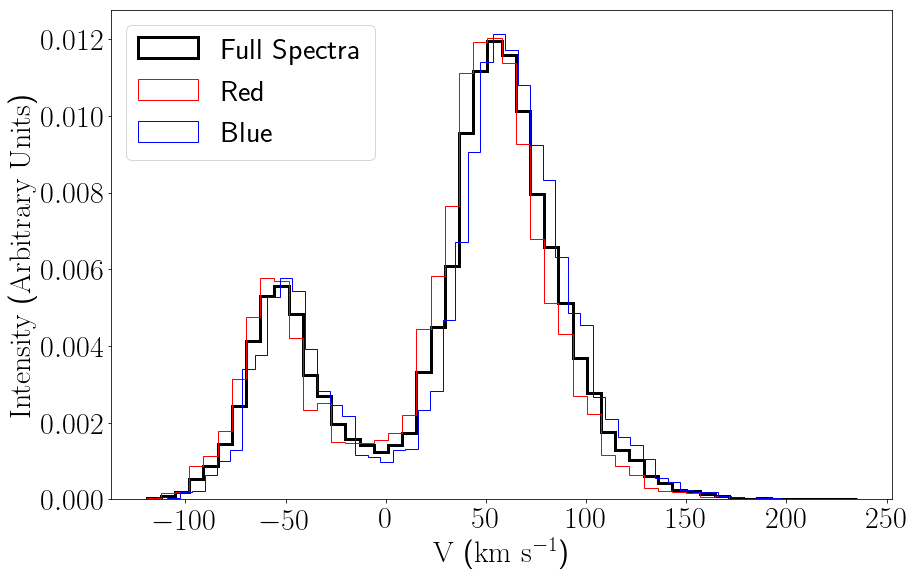

In [94]:
plot_redshift(vout=25, vrot=50, logtau=5)